# Исследование надежности заемщиков


Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.


Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.


## Общее изучение данных

In [1]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

Загрузим данные.

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


## Предобработка данных

### Удаление пропусков

Выведем количество пропущенных значений для каждого столбца.

In [5]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

В двух столбцах есть пропущенные значения. Один из них — `days_employed`. Пропуски в этом столбце мы обработаем на следующем этапе.
Другой столбец с пропущенными значениями — `total_income` — хранит данные о доходах. На сумму дохода сильнее всего влияет тип занятости, поэтому заполнить пропуски в этом столбце нужно медианным значением по каждому типу из столбца `income_type`.

In [6]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

### Обработка аномальных значений

Отрицательное количество дней трудового стажа в столбце `days_employed` будет являться аномальным значением.Заменим все отрицательные значения положительными с помощью метода `abs()`.

In [7]:
data['days_employed'] = data['days_employed'].abs()

Для каждого типа занятости выведем медианное значение трудового стажа `days_employed` в днях.

In [8]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

У двух типов (безработные и пенсионеры) получатся аномально большие значения. Поскольку этот столбец не понадобится для исследования, оставим значения как есть.

Выведем перечень уникальных значений столбца `children`.

In [9]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

В столбце `children` есть два аномальных значения. Удалим строки, в которых встречаются такие аномальные значения из датафрейма `data`.

In [10]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

Убедимся, что аномалии удалены.

In [11]:
data['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

### Удаление пропусков (продолжение)

Заполним пропуски в столбце `days_employed` медианными значениями по каждого типа занятости `income_type`.

In [12]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

Убедимся, что все пропуски заполнены. Выведем количество пропущенных значений для каждого столбца.

In [13]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Изменение типов данных

Заменим вещественный тип данных в столбце `total_income` на целочисленный с помощью метода `astype()`.

In [14]:
data['total_income'] = data['total_income'].astype(int)

### Обработка дубликатов

Обработаем неявные дубликаты в столбце `education`. В этом столбце есть одни и те же значения, но записанные по-разному: с использованием заглавных и строчных букв. Приведем их к нижнему регистру. Проверим остальные столбцы.

In [15]:
data['education'] = data['education'].str.lower()

Выведем на экран количество строк-дубликатов в данных и удалим дубликаты.

In [16]:
data.duplicated().sum()

71

In [17]:
data = data.drop_duplicates()

### Категоризация данных

На основании диапазонов, указанных ниже, создадим в датафрейме `data` столбец `total_income_category` с категориями:

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

In [18]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [19]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

Выведим на экран перечень уникальных целей взятия кредита из столбца `purpose`.

In [20]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Создадим функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

In [21]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [22]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

## Исследование данных

### Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [23]:
#статистика по количеству детей
print('Количество детей:\n', data['children'].value_counts())

Количество детей:
 0    14091
1     4808
2     2052
3      330
4       41
5        9
Name: children, dtype: int64


In [24]:
# процент числа детей в семье
print('Количество детей, доля %:\n', data['children'].value_counts() / data['children'].count()*100)

Количество детей, доля %:
 0    66.058788
1    22.539965
2     9.619802
3     1.547044
4     0.192209
5     0.042192
Name: children, dtype: float64


In [25]:
print('Количество случаев невозврата кредита в срок:\n',
      data.groupby('children')['debt'].sum()) #количество случаев невозврата кредита в срок

Количество случаев невозврата кредита в срок:
 children
0    1063
1     444
2     194
3      27
4       4
5       0
Name: debt, dtype: int64


In [26]:
#доля имеющих задолженность в зависимости от количества детей
data_children = data.groupby('children')['debt'].sum() / data['children'].value_counts()
print('Имели задолженность по возврату кредита (в зависимости от количества детей, %):\n',
      round(data_children * 100, 2)) #доля в процентах

Имели задолженность по возврату кредита (в зависимости от количества детей, %):
 children
0    7.54
1    9.23
2    9.45
3    8.18
4    9.76
5    0.00
dtype: float64


Построим график зависимости между количеством детей и возвратом кредита в срок.

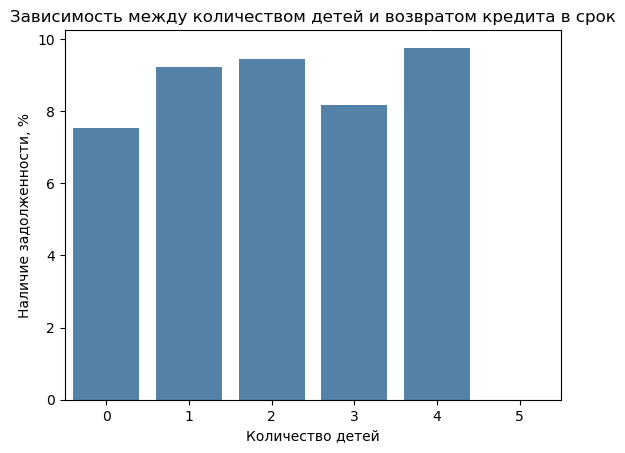

In [27]:
children = [0,1,2,3,4,5]
seaborn.barplot(x=children, y=data_children*100, color='#4682B4');

plt.title('Зависимость между количеством детей и возвратом кредита в срок')
plt.xlabel('Количество детей')
plt.ylabel('Наличие задолженности, %')
plt.show()

**Вывод:** количество детей в целом слабо влияет на вероятность возврата кредита в срок.
При этом, отсутствие детей повышает вероятность соблюдения сроков на ~2%.

Следует отметить, что в представленной выборке полностью отсутствуют случаи задолженностей по кредитам при наличии пятерых детей, но общее количество таких случаев составляет менее 0,05%, а значит такой результат можно объяснить статистической погрешностью.

Детей нет у 66% заёмщиков, однин ребёнок - у 22,5%. Оставшиеся категории составляют 11,5% от общего числа клиентов.

### Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [28]:
print(data.groupby(['family_status_id', 'family_status'])['debt'].sum())

family_status_id  family_status        
0                 женат / замужем          927
1                 гражданский брак         385
2                 вдовец / вдова            63
3                 в разводе                 84
4                 Не женат / не замужем    273
Name: debt, dtype: int64


In [29]:
#семейное положение - количество
print('Семейное положение:\n', data.groupby('family_status_id')['debt'].count())

Семейное положение:
 family_status_id
0    12261
1     4134
2      951
3     1189
4     2796
Name: debt, dtype: int64


In [30]:
#семейное положение - процент
print('Семейное положение, %:\n', data['family_status'].value_counts() / data['family_status'].count() *100)

Семейное положение, %:
 женат / замужем          57.479724
гражданский брак         19.380245
Не женат / не замужем    13.107684
в разводе                 5.574047
вдовец / вдова            4.458300
Name: family_status, dtype: float64


In [31]:
print('Количество задолженностей в зависимости от семейного положения:\n',
      data.groupby('family_status_id')['debt'].sum()) #количество задолженностей в зависимости от семейного положения

Количество задолженностей в зависимости от семейного положения:
 family_status_id
0    927
1    385
2     63
3     84
4    273
Name: debt, dtype: int64


In [32]:
data_family = data.groupby('family_status')['debt'].sum() / data.groupby('family_status')['debt'].count()
print('Имели задолженность по возврату кредита (в зависимости от семейного положения, %):\n',
      round(data_family * 100, 2))

Имели задолженность по возврату кредита (в зависимости от семейного положения, %):
 family_status
Не женат / не замужем    9.76
в разводе                7.06
вдовец / вдова           6.62
гражданский брак         9.31
женат / замужем          7.56
Name: debt, dtype: float64


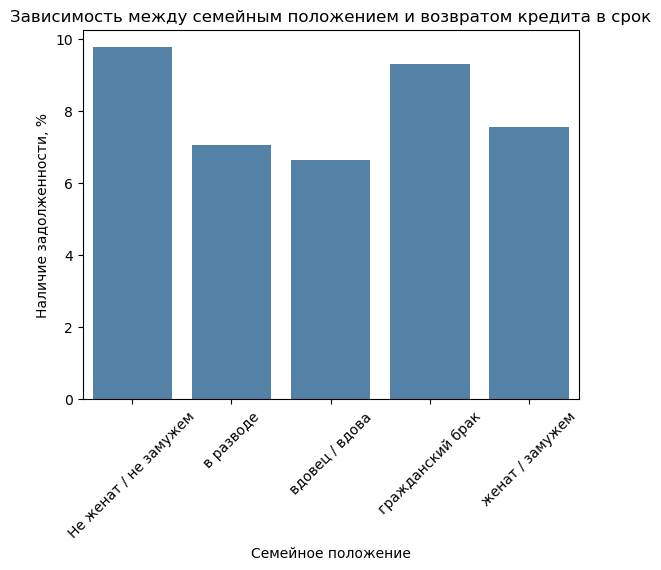

In [33]:
seaborn.barplot(x=sorted(data['family_status'].unique()), y=data_family*100, color='#4682B4');

plt.title('Зависимость между семейным положением и возвратом кредита в срок')
plt.xlabel('Семейное положение')
plt.ylabel('Наличие задолженности, %')
plt.xticks(rotation=45)
plt.show()

**Вывод:** две категории заёмщиков выделяются повышенной на ~2% долей наличия задолженностей по кредитам - не женатые и состоящие в гражданском браке - 9,8% и 9,3% соответственно.

Самая низкая доля задолженности у категории заёмщиков "вдовец / вдова" - 6,6%.

Самая многочисленная категория - "женат/замужем" (57,5%), самые малочисленные - "вдовец / вдова" (5,6%) и "в разводе" (4,5%).

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [34]:
print('Категории дохода:\n',
      data.groupby('total_income_category')['debt'].count()) #группировка по доходу - количество людей

Категории дохода:
 total_income_category
A       25
B     5014
C    15921
D      349
E       22
Name: debt, dtype: int64


In [35]:
print('Распределение займщиков по ежемесячному доходу, %:\n',
      data.groupby('total_income_category')['debt'].count() / data['total_income_category'].count()*100)

Распределение займщиков по ежемесячному доходу, %:
 total_income_category
A     0.117200
B    23.505696
C    74.637851
D     1.636116
E     0.103136
Name: debt, dtype: float64


In [36]:
print('Количество задолженностей в зависимости от дохода:\n',
      data.groupby('total_income_category')['debt'].sum()) #количество задолженностей в зависимости от дохода

Количество задолженностей в зависимости от дохода:
 total_income_category
A       2
B     354
C    1353
D      21
E       2
Name: debt, dtype: int64


In [37]:
data_tic = data.groupby('total_income_category')['debt'].sum() / data.groupby('total_income_category')['debt'].count()
print('Имели задолженность по возврату кредита (в зависимости от ежемесячного дохода, %):\n',
      round(data_tic * 100, 2))

Имели задолженность по возврату кредита (в зависимости от ежемесячного дохода, %):
 total_income_category
A    8.00
B    7.06
C    8.50
D    6.02
E    9.09
Name: debt, dtype: float64


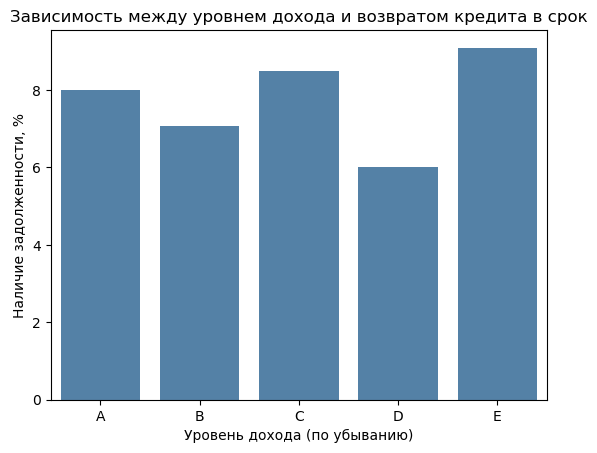

In [38]:
seaborn.barplot(data=data, x='total_income_category', y=data['debt']*100, \
                color='#4682B4', order=sorted(data['total_income_category'].unique()), ci=None);

plt.title('Зависимость между уровнем дохода и возвратом кредита в срок')
plt.xlabel('Уровень дохода (по убыванию)')
plt.ylabel('Наличие задолженности, %')
plt.show()

**Вывод:** наименьшее количество задолженностей у заёмщиков с доходом категории D, наибольшее - с доходом категории E.

75% заёмщиков из выборки имеют средний уровень дохода - категория C. 24% заёмщиков имеют доход категории B. На оставшиеся уровни дохода приходится 1% заёмщиков.

Таким образом, распределение заёмщиков по категориям дохода является неравномерным и не позволяет с достаточной степенью уверенности судить о возможности возникновения задолженности по кредиту на основании уровня дохода, отличающегося от среднего.

Поскольку 99% заёмщиков имеют уровень дохода от 50001 до 1000000, соответствующие категории дохода (B, C) целесообразно разбить на более мелкие группы.

### Как разные цели кредита влияют на его возврат в срок?

In [39]:
#группировка по цели - количество людей
print('Цель кредита:\n', data.groupby('purpose_category')['debt'].count())

Цель кредита:
 purpose_category
операции с автомобилем       4279
операции с недвижимостью    10751
получение образования        3988
проведение свадьбы           2313
Name: debt, dtype: int64


In [40]:
print('Распределение займщиков по цели, %:\n',
      data.groupby('purpose_category')['debt'].count() / data['purpose_category'].count()*100)

Распределение займщиков по цели, %:
 purpose_category
операции с автомобилем      20.060007
операции с недвижимостью    50.400825
получение образования       18.695795
проведение свадьбы          10.843373
Name: debt, dtype: float64


In [41]:
#количество задолженностей в зависимости от цели
print('Количество задолженностей в зависимости от цели:\n',
      data.groupby('purpose_category')['debt'].sum())

Количество задолженностей в зависимости от цели:
 purpose_category
операции с автомобилем      400
операции с недвижимостью    780
получение образования       369
проведение свадьбы          183
Name: debt, dtype: int64


In [42]:
data_purpose = data.groupby('purpose_category')['debt'].sum() / data.groupby('purpose_category')['debt'].count()
print('Имели задолженность по возврату кредита (в зависимости от цели, %):\n',
      round(data_purpose * 100, 2))

Имели задолженность по возврату кредита (в зависимости от цели, %):
 purpose_category
операции с автомобилем      9.35
операции с недвижимостью    7.26
получение образования       9.25
проведение свадьбы          7.91
Name: debt, dtype: float64


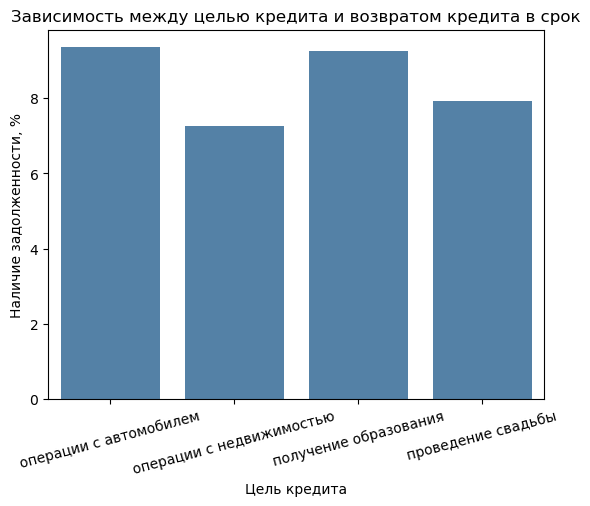

In [43]:
seaborn.barplot(data=data, x='purpose_category', y=data['debt']*100, \
                color='#4682B4', order=sorted(data['purpose_category'].unique()), ci=None);

plt.title('Зависимость между целью кредита и возвратом кредита в срок')
plt.xlabel('Цель кредита')
plt.ylabel('Наличие задолженности, %')
plt.xticks(rotation=15)
plt.show()

**Вывод:** наименьший процент задолженностей наблюдается у людей, цель которых - операции с недвижимостью. Также это самая крупная категория, составляющая 50% от всех целей.

Больше всего задолженностей в категориях "операции с автомобилем" и "получение образования".

Разница между минимальным и максимальным процентом задолженностей составляет 2%.

### Возможные причины появления пропусков в исходных данных.

Пропуски в данном случае присутствуют в сведениях о трудовом стаже и ежемесячном доходе. Такие пропуски могут быть намеренными. Например, при нежелании заёмщика указывать соответствующую информацию, либо при отутствии стажа или дохода. Также нельзя исключать технические сбои при сохранении, копировании, выгрузке информации.

### Почему заполнить пропуски медианным значением — лучшее решение для количественных переменных.

Медианное значение позволяет снизить влияние максимальных и минимальных значений.

## Общий вывод.

**Задача:** на основании статистики о платёжеспособности клиентов проанализировать влияние различных факторов на факт погашения кредита в срок для создания системы, оценивающей способность потенциального заёмщика вернуть кредит банку.

**Выводы:**
- количество детей слабо влияет на вероятность возврата кредита в срок. При этом, отсутствие детей повышает вероятность соблюдения сроков на ~2%;
- две категории заёмщиков выделяются повышенной на ~2% долей наличия задолженностей по кредитам - не женатые и состоящие в гражданском браке;
- наименьшее количество задолженностей у заёмщиков с ежемесячным доходом 30000–50000, наибольшее - с доходом менее 30000;
- наименьший процент задолженностей наблюдается у людей, цель которых - операции с недвижимостью. Больше всего задолженностей в категориях "операции с автомобилем" и "получение образования".

**Лучший заёмщик:** бездетный вдовец/вдова с доходом 30000–50000, желающий купить квартиру.

**Худший заёмщик:** состоящий в гражданском браке, имеющий ребенка (или нескольких), с доходом менее 30000, желающий купить машину.